Dans ce notebook on entraine deux modèles, avec et sans augmentation, basés sur du transfer learning avec VGG16 pour compter le nombre de noyaux à partir d'image de contours de cellules d'histopathologie.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tifffile as tiff
import os
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, LeakyReLU, ReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, Rescaling
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras import models,layers


from tensorflow.keras.utils import Sequence

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1qFvibfcAVni3Kw13FtC_8NqEdH8OzTIQ

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1qFvibfcAVni3Kw13FtC_8NqEdH8OzTIQ
To: /content/data.rar
100% 903M/903M [00:18<00:00, 49.1MB/s]


In [ ]:
!unrar x "/content/data.rar" "/content/data/"
! rm "/content/data.rar"

Streaming output truncated to the last 5000 lines.
Extracting  /content/data/patch_gt_test/TCGA-A6-6782-01A-01-BS1_17.tif      98%  OK 
Extracting  /content/data/patch_gt_test/TCGA-A6-6782-01A-01-BS1_18.tif      98%  OK 
Extracting  /content/data/patch_gt_test/TCGA-A6-6782-01A-01-BS1_19.tif      98%  OK 
Extracting  /content/data/patch_gt_test/TCGA-A6-6782-01A-01-BS1_2.tif      98%  OK 
Extracting  /content/data/patch_gt_test/TCGA-A6-6782-01A-01-BS1_20.tif      98%  OK 
Extracting  /content/data/patch_gt_test/TCGA-A6-6782-01A-01-BS1_21.tif      98%  OK 
Extracting  /content/data/patch_gt_test/TCGA-A6-6782-01A-01-BS1_22.tif      98%  OK 
Extracting  /content/data/patch_gt_test/TCGA-A6-6782-01A-01-BS1_23.tif      98%  OK 
Extracting  /content/data/patch_gt_test/TCGA-A6-6782-01A-01-BS1_24.tif      98%  OK 
Extracting  /content/data/patch_gt_test/TCGA-A6-6782-01A-01-BS1_25.tif      98%  OK 
Extracting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

In [ ]:
path_x_train = '/content/data/contour_gt_train/'
path_y_train = '/content/data/patch_gt_train/'

path_x_test = '/content/data/contour_gt_test/'
path_y_test = '/content/data/patch_gt_test/'

In [ ]:
nb_noyau_train = []
im_train = []
f_x_train= os.listdir(path_x_train)

print("Loading",len(f_x_train)," training images.")
for i,k in enumerate(f_x_train):
    if i%100 == 0 : print(i,end=', ')
    im_train.append(tiff.imread(path_x_train+k).astype(int)*255)
    nb_noyau_train.append(len(np.unique(tiff.imread(path_y_train+k))))
print(".Done.")

nb_noyau_train = np.array(nb_noyau_train)
im_train = np.array(im_train)
im_train = np.expand_dims(im_train,axis=-1)

nb_noyau_test = []
im_test = []
f_x_test= os.listdir(path_x_test)

print("Loading",len(f_x_test)," testing images.")
for i,k in enumerate(f_x_test):
    if i%100 == 0 : print(i,end=', ')
    im_test.append(tiff.imread(path_x_test+k).astype(int)*255)
    nb_noyau_test.append(len(np.unique(tiff.imread(path_y_test+k))))
print(".Done.")
nb_noyau_test = np.array(nb_noyau_test)
im_test = np.array(im_test)
im_test = np.expand_dims(im_test,axis=-1)

Loading 4468  training images.
0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, .Done.
Loading 686  testing images.
0, 100, 200, 300, 400, 500, 600, .Done.


In [ ]:
idx = np.arange(len(im_train))
np.random.shuffle(idx)
X_train = im_train[idx]
Y_train = nb_noyau_train[idx]

X_test = im_test[:]
Y_test = nb_noyau_test[:]

# Training without augmentation

In [ ]:
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

def lr_step_decay(epoch, lr):
    drop_rate = 0.8
    epochs_drop = 5.0
    return initial_learning_rate * np.power(drop_rate, np.floor(epoch/epochs_drop))

In [ ]:
idx = np.arange(len(im_train))
np.random.shuffle(idx)
X_train = im_train[idx]
Y_train = nb_noyau_train[idx]

X_test = im_test[:]
Y_test = nb_noyau_test[:]

## Initial training

In [ ]:
base_model = VGG16(weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)
base_model.trainable = False
#base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
inputs = Input(shape=(256,256,1))
x = Conv2D(3,(3,3),padding='same',activation=LeakyReLU(0.2))(inputs)
x = preprocess_input(x)
x = base_model(x,training=False)

x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
x = Flatten()(x)
x = Dense(32,activation=LeakyReLU(0.2))(x)

outputs = Dense(1,activation='linear')(x)
vgg_transfer = Model(inputs,outputs)
vgg_transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 3)       30        
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 512)        0         
 )                                                           

In [ ]:
initial_learning_rate = 0.01
epochs = 20
decay = initial_learning_rate / epochs

optimizer = Adam(initial_learning_rate)
vgg_transfer.compile(optimizer=optimizer,loss = "mean_squared_error", metrics = "mean_absolute_error" )

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=5,verbose=1)

checkpoint_filepath ='/content/drive/MyDrive/IMA206/best_model_b4_fine_tune'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True)
history_logger=tf.keras.callbacks.CSVLogger("/content/drive/MyDrive/IMA206/history_model.csv",append=True)


In [ ]:
with tf.device("/GPU:0"):
    history = vgg_transfer.fit(
        X_train, Y_train,
        batch_size=32,
        validation_split=0.2,
        epochs=epochs, 
        callbacks=[LearningRateScheduler(lr_step_decay, verbose=1),model_checkpoint_callback,tf.keras.callbacks.TerminateOnNaN(),
                    history_logger],
        verbose = 1
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40
112/112 [==============================] - ETA: 0s - loss: 8413.9609 - mean_absolute_error: 34.2770

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_1/assets


112/112 [==============================] - 78s 517ms/step - loss: 8413.9609 - mean_absolute_error: 34.2770 - val_loss: 110.1730 - val_mean_absolute_error: 7.3760 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/40
112/112 [==============================] - ETA: 0s - loss: 101.6074 - mean_absolute_error: 6.4030

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_2/assets


112/112 [==============================] - 52s 462ms/step - loss: 101.6074 - mean_absolute_error: 6.4030 - val_loss: 61.0882 - val_mean_absolute_error: 5.6116 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/40
112/112 [==============================] - ETA: 0s - loss: 56.0269 - mean_absolute_error: 5.0474

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_3/assets


112/112 [==============================] - 51s 457ms/step - loss: 56.0269 - mean_absolute_error: 5.0474 - val_loss: 47.9238 - val_mean_absolute_error: 5.0777 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/40
112/112 [==============================] - ETA: 0s - loss: 39.4193 - mean_absolute_error: 4.3627

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_4/assets


112/112 [==============================] - 51s 458ms/step - loss: 39.4193 - mean_absolute_error: 4.3627 - val_loss: 40.9554 - val_mean_absolute_error: 4.6555 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/40
112/112 [==============================] - ETA: 0s - loss: 28.5254 - mean_absolute_error: 3.7286

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_5/assets


112/112 [==============================] - 51s 456ms/step - loss: 28.5254 - mean_absolute_error: 3.7286 - val_loss: 36.9577 - val_mean_absolute_error: 4.3792 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.008.
Epoch 6/40
112/112 [==============================] - 49s 434ms/step - loss: 22.2385 - mean_absolute_error: 3.3068 - val_loss: 40.1442 - val_mean_absolute_error: 4.5772 - lr: 0.0080

Epoch 7: LearningRateScheduler setting learning rate to 0.008.
Epoch 7/40
112/112 [==============================] - 49s 434ms/step - loss: 18.9655 - mean_absolute_error: 3.0802 - val_loss: 37.3635 - val_mean_absolute_error: 4.3624 - lr: 0.0080

Epoch 8: LearningRateScheduler setting learning rate to 0.008.
Epoch 8/40
112/112 [==============================] - ETA: 0s - loss: 16.4146 - mean_absolute_error: 2.8768

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_8/assets


112/112 [==============================] - 51s 459ms/step - loss: 16.4146 - mean_absolute_error: 2.8768 - val_loss: 35.0330 - val_mean_absolute_error: 4.1860 - lr: 0.0080

Epoch 9: LearningRateScheduler setting learning rate to 0.008.
Epoch 9/40
112/112 [==============================] - 49s 434ms/step - loss: 14.6245 - mean_absolute_error: 2.7164 - val_loss: 35.3449 - val_mean_absolute_error: 4.1906 - lr: 0.0080

Epoch 10: LearningRateScheduler setting learning rate to 0.008.
Epoch 10/40
112/112 [==============================] - 49s 434ms/step - loss: 13.8356 - mean_absolute_error: 2.7230 - val_loss: 37.3361 - val_mean_absolute_error: 4.3900 - lr: 0.0080

Epoch 11: LearningRateScheduler setting learning rate to 0.006400000000000001.
Epoch 11/40
112/112 [==============================] - 49s 434ms/step - loss: 11.3531 - mean_absolute_error: 2.4312 - val_loss: 36.2584 - val_mean_absolute_error: 4.3037 - lr: 0.0064

Epoch 12: LearningRateScheduler setting learning rate to 0.006400000000

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data at the end of the training")
with tf.device("/GPU:0"):
    results = vgg_transfer.evaluate(X_test, Y_test, batch_size=32)
    np.savetxt("/content/drive/MyDrive/IMA206/result before fine tuning_end of training.txt",results)
print("test loss (MSE), test mean_absolute_error:", results)

Evaluate on test data at the end of the training
22/22 [==============================] - 4s 185ms/step - loss: 37.1426 - mean_absolute_error: 4.5246
test loss (MSE), test mean_absolute_error: [37.14259338378906, 4.524642467498779]


dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error', 'lr'])


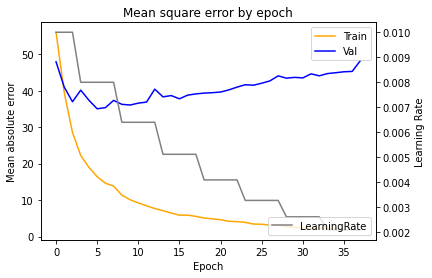

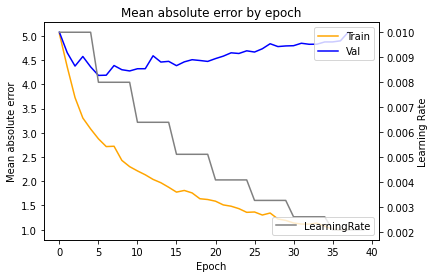

In [ ]:
h = history.history
print(h.keys())

ax1 = plt.subplot()
l1 = ax1.plot(h["loss"][2:],label="Train",color='orange')
l2 = ax1.plot(h["val_loss"][2:],label="Val",color='blue')
ax1.legend(loc=1)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Mean absolute error")

ax2 = ax1.twinx()
ax2.plot(h["lr"][2:],label="LearningRate",color='grey')
ax2.legend(loc=4)
ax2.set_ylabel("Learning Rate")

plt.title("Mean square error by epoch")
plt.savefig("/content/drive/MyDrive/IMA206/MSE_by_epoch_full_training.png")
plt.show()

ax1 = plt.subplot()
l1 = ax1.plot(h["mean_absolute_error"][2:],label="Train",color='orange')
l2 = ax1.plot(h["val_mean_absolute_error"][2:],label="Val",color='blue')
ax1.legend(loc=1)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Mean absolute error")

ax2 = ax1.twinx()
ax2.plot(h["lr"][:],label="LearningRate",color='grey')
ax2.legend(loc=4)
ax2.set_ylabel("Learning Rate")

plt.title("Mean absolute error by epoch")
plt.savefig("/content/drive/MyDrive/IMA206/MAE_by_epoch_full_training.png")
plt.show()


## Fine tuning

In [ ]:
vgg_transfer = tf.keras.models.load_model('/content/drive/MyDrive/IMA206/best_model_b4_fine_tune')
vgg_transfer.get_layer('vgg16').trainable = True
vgg_transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 3)       30        
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 512)        0         
 )                                                           

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data at the end of the training the best model found")
with tf.device("/GPU:0"):
    results = vgg_transfer.evaluate(X_test, Y_test, batch_size=32)
    np.savetxt("/content/drive/MyDrive/IMA206/result before fine tuning_best model found.txt",results)
print("test loss (MSE), test mean_absolute_error:", results)

Evaluate on test data at the end of the training the best model found
22/22 [==============================] - 4s 186ms/step - loss: 21.8283 - mean_absolute_error: 3.5873
test loss (MSE), test mean_absolute_error: [21.828285217285156, 3.5872578620910645]


In [ ]:
initial_learning_rate = 1e-5
epochs = 20
decay = initial_learning_rate / epochs

optimizer = Adam(initial_learning_rate)
vgg_transfer.compile(optimizer=optimizer,loss = "mean_squared_error", metrics = "mean_absolute_error" )

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=5,verbose=1)

checkpoint_filepath = '/content/drive/MyDrive/IMA206/best_model_fine_tuned'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True)
history_logger=tf.keras.callbacks.CSVLogger("/content/drive/MyDrive/IMA206/history_model_fine_tuned.csv",append=True)


In [ ]:
with tf.device("/GPU:0"):
    history = vgg_transfer.fit(
        X_train, Y_train,
        batch_size=32,
        validation_split=0.2,
        epochs=epochs, 
        callbacks=[LearningRateScheduler(lr_step_decay, verbose=1),model_checkpoint_callback,tf.keras.callbacks.TerminateOnNaN(),
                    history_logger],
        verbose = 1
    )


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20
112/112 [==============================] - ETA: 0s - loss: 45.3751 - mean_absolute_error: 4.2551

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


112/112 [==============================] - 72s 634ms/step - loss: 45.3751 - mean_absolute_error: 4.2551 - val_loss: 18.8393 - val_mean_absolute_error: 3.1478 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/20
112/112 [==============================] - ETA: 0s - loss: 29.5684 - mean_absolute_error: 3.2901

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


112/112 [==============================] - 71s 632ms/step - loss: 29.5684 - mean_absolute_error: 3.2901 - val_loss: 16.6680 - val_mean_absolute_error: 2.8705 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-05.
Epoch 3/20
112/112 [==============================] - 67s 598ms/step - loss: 15.7990 - mean_absolute_error: 2.5510 - val_loss: 17.7638 - val_mean_absolute_error: 2.9977 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1e-05.
Epoch 4/20
112/112 [==============================] - ETA: 0s - loss: 17.7735 - mean_absolute_error: 2.6573

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


112/112 [==============================] - 70s 627ms/step - loss: 17.7735 - mean_absolute_error: 2.6573 - val_loss: 12.5883 - val_mean_absolute_error: 2.5389 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/20
112/112 [==============================] - 67s 598ms/step - loss: 10.0517 - mean_absolute_error: 2.0519 - val_loss: 15.6367 - val_mean_absolute_error: 3.0172 - lr: 1.0000e-05

Epoch 6: LearningRateScheduler setting learning rate to 8.000000000000001e-06.
Epoch 6/20
112/112 [==============================] - ETA: 0s - loss: 5.4472 - mean_absolute_error: 1.6403

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


112/112 [==============================] - 71s 631ms/step - loss: 5.4472 - mean_absolute_error: 1.6403 - val_loss: 11.1417 - val_mean_absolute_error: 2.4257 - lr: 8.0000e-06

Epoch 7: LearningRateScheduler setting learning rate to 8.000000000000001e-06.
Epoch 7/20
112/112 [==============================] - ETA: 0s - loss: 3.6442 - mean_absolute_error: 1.3947

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


112/112 [==============================] - 70s 630ms/step - loss: 3.6442 - mean_absolute_error: 1.3947 - val_loss: 10.4878 - val_mean_absolute_error: 2.3162 - lr: 8.0000e-06

Epoch 8: LearningRateScheduler setting learning rate to 8.000000000000001e-06.
Epoch 8/20
112/112 [==============================] - ETA: 0s - loss: 2.5544 - mean_absolute_error: 1.1771

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


112/112 [==============================] - 71s 632ms/step - loss: 2.5544 - mean_absolute_error: 1.1771 - val_loss: 10.2962 - val_mean_absolute_error: 2.3033 - lr: 8.0000e-06

Epoch 9: LearningRateScheduler setting learning rate to 8.000000000000001e-06.
Epoch 9/20
112/112 [==============================] - 67s 599ms/step - loss: 1.9744 - mean_absolute_error: 1.0348 - val_loss: 11.3703 - val_mean_absolute_error: 2.4044 - lr: 8.0000e-06

Epoch 10: LearningRateScheduler setting learning rate to 8.000000000000001e-06.
Epoch 10/20
112/112 [==============================] - ETA: 0s - loss: 1.7779 - mean_absolute_error: 0.9481

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


112/112 [==============================] - 70s 626ms/step - loss: 1.7779 - mean_absolute_error: 0.9481 - val_loss: 10.0804 - val_mean_absolute_error: 2.2731 - lr: 8.0000e-06

Epoch 11: LearningRateScheduler setting learning rate to 6.400000000000001e-06.
Epoch 11/20
112/112 [==============================] - 67s 598ms/step - loss: 4.3047 - mean_absolute_error: 1.3151 - val_loss: 10.9143 - val_mean_absolute_error: 2.3405 - lr: 6.4000e-06

Epoch 12: LearningRateScheduler setting learning rate to 6.400000000000001e-06.
Epoch 12/20
112/112 [==============================] - 67s 597ms/step - loss: 2.2724 - mean_absolute_error: 0.9514 - val_loss: 11.8830 - val_mean_absolute_error: 2.5523 - lr: 6.4000e-06

Epoch 13: LearningRateScheduler setting learning rate to 6.400000000000001e-06.
Epoch 13/20
112/112 [==============================] - 67s 598ms/step - loss: 2.1706 - mean_absolute_error: 0.9731 - val_loss: 10.9403 - val_mean_absolute_error: 2.4506 - lr: 6.4000e-06

Epoch 14: LearningRateSc

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


112/112 [==============================] - 70s 630ms/step - loss: 1.9378 - mean_absolute_error: 0.9212 - val_loss: 9.8013 - val_mean_absolute_error: 2.2287 - lr: 5.1200e-06

Epoch 17: LearningRateScheduler setting learning rate to 5.120000000000002e-06.
Epoch 17/20
112/112 [==============================] - ETA: 0s - loss: 1.1249 - mean_absolute_error: 0.7188

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned/assets


112/112 [==============================] - 70s 627ms/step - loss: 1.1249 - mean_absolute_error: 0.7188 - val_loss: 9.5188 - val_mean_absolute_error: 2.2069 - lr: 5.1200e-06

Epoch 18: LearningRateScheduler setting learning rate to 5.120000000000002e-06.
Epoch 18/20
112/112 [==============================] - 67s 599ms/step - loss: 0.4794 - mean_absolute_error: 0.4919 - val_loss: 9.6648 - val_mean_absolute_error: 2.2155 - lr: 5.1200e-06

Epoch 19: LearningRateScheduler setting learning rate to 5.120000000000002e-06.
Epoch 19/20
112/112 [==============================] - 67s 598ms/step - loss: 0.3465 - mean_absolute_error: 0.4297 - val_loss: 9.5906 - val_mean_absolute_error: 2.2090 - lr: 5.1200e-06

Epoch 20: LearningRateScheduler setting learning rate to 5.120000000000002e-06.
Epoch 20/20
112/112 [==============================] - 67s 597ms/step - loss: 0.2458 - mean_absolute_error: 0.3640 - val_loss: 9.6767 - val_mean_absolute_error: 2.2196 - lr: 5.1200e-06


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data at the end of the training")
with tf.device("/GPU:0"):
    results = vgg_transfer.evaluate(X_test, Y_test, batch_size=32)
    np.savetxt("/content/drive/MyDrive/IMA206/result after fine tuning_end of training.txt",results)
print("test loss, test acc:", results)

Evaluate on test data at the end of the training
22/22 [==============================] - 4s 190ms/step - loss: 7.7899 - mean_absolute_error: 2.2033
test loss, test acc: [7.789860248565674, 2.203348398208618]


dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error', 'lr'])


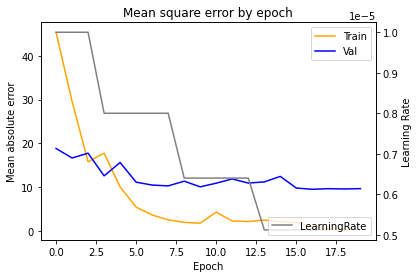

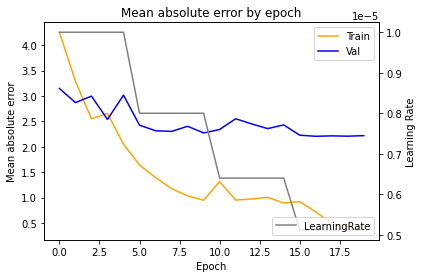

In [ ]:
h = history.history
print(h.keys())

ax1 = plt.subplot()
l1 = ax1.plot(h["loss"][:],label="Train",color='orange')
l2 = ax1.plot(h["val_loss"][:],label="Val",color='blue')
ax1.legend(loc=1)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Mean absolute error")

ax2 = ax1.twinx()
ax2.plot(h["lr"][2:],label="LearningRate",color='grey')
ax2.legend(loc=4)
ax2.set_ylabel("Learning Rate")

plt.title("Mean square error by epoch")
plt.savefig("/content/drive/MyDrive/IMA206/MSE_by_epoch_full_training_fine_tuned.png")
plt.show()

ax1 = plt.subplot()
l1 = ax1.plot(h["mean_absolute_error"][:],label="Train",color='orange')
l2 = ax1.plot(h["val_mean_absolute_error"][:],label="Val",color='blue')
ax1.legend(loc=1)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Mean absolute error")

ax2 = ax1.twinx()
ax2.plot(h["lr"][:],label="LearningRate",color='grey')
ax2.legend(loc=4)
ax2.set_ylabel("Learning Rate")

plt.title("Mean absolute error by epoch")
plt.savefig("/content/drive/MyDrive/IMA206/MAE_by_epoch_full_training_fine_tuned.png")
plt.show()


## Evaluate

In [ ]:
vgg_transfer = tf.keras.models.load_model('/content/drive/MyDrive/IMA206/best_model_fine_tuned')
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data at the end of the training")
with tf.device("/GPU:0"):
    results = vgg_transfer.evaluate(X_test, Y_test, batch_size=32)
    np.savetxt("/content/drive/MyDrive/IMA206/result after fine tuning_best_model_found.txt",results)
print("test loss, test acc:", results)

Evaluate on test data at the end of the training
22/22 [==============================] - 20s 251ms/step - loss: 7.8636 - mean_absolute_error: 2.2110
test loss, test acc: [7.86361026763916, 2.210982084274292]


In [ ]:
X_test_rot_90 = np.rot90(X_test,k=1,axes=(1,2))
X_test_rot_180 = np.rot90(X_test,k=2,axes=(1,2))
X_test_rot_270 = np.rot90(X_test,k=3,axes=(1,2))
with tf.device("/GPU:0"):
    results_0 = vgg_transfer.predict(X_test,batch_size=32)
    results_90 = vgg_transfer.predict(X_test_rot_90, batch_size=32)
    results_180 = vgg_transfer.predict(X_test_rot_180, batch_size=32)
    results_270 = vgg_transfer.predict(X_test_rot_270, batch_size=32)
    

In [ ]:
results_0 = np.round(results_0.reshape(-1))
results_90 = np.round(results_90.reshape(-1))
results_180 = np.round(results_180.reshape(-1))
results_270 = np.round(results_270.reshape(-1))

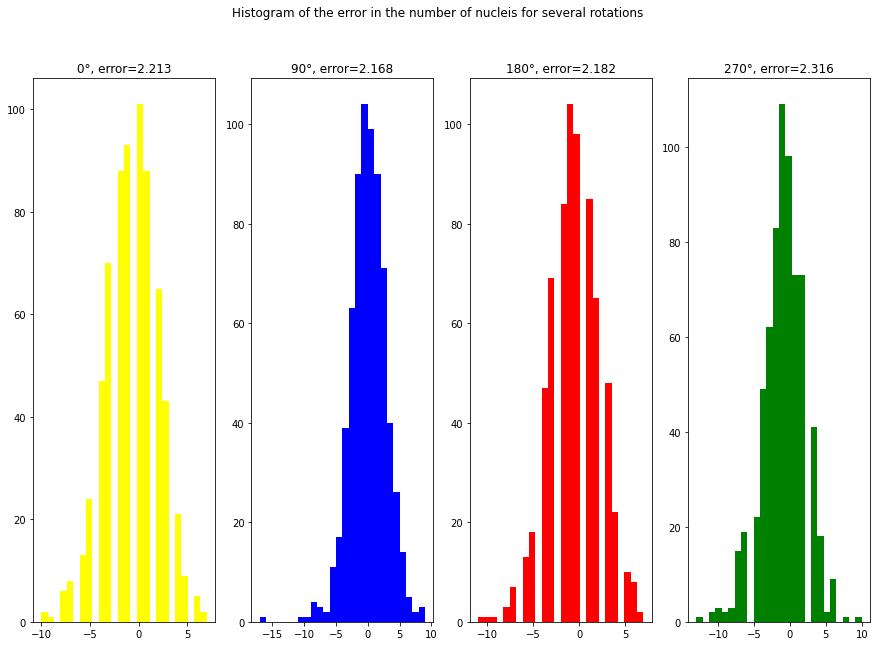

Average error 0 2.1676384839650145
Average error 90 2.1676384839650145
Average error 180 2.182215743440233
Average error 270 2.316326530612245


In [ ]:
delta_0 = Y_test - results_0
delta_90 = Y_test - results_90
delta_180 = Y_test - results_180
delta_270 = Y_test - results_270

fig, ax = plt.subplots(1,4,figsize=(15,10))
ax[0].hist(delta_0, bins=26,range=(np.min(delta_0),np.max(delta_0)), color="yellow") 
ax[0].set_title("0°, error="+ str(np.round(np.abs(delta_0).mean(),3)))
ax[1].hist(delta_90, bins=26,range=(np.min(delta_90),np.max(delta_90)), color="blue" )
ax[1].set_title("90°, error="+ str(np.round(np.abs(delta_90).mean(),3)))
ax[2].hist(delta_180, bins=26,range=(np.min(delta_180),np.max(delta_180)),color="red")
ax[2].set_title("180°, error="+ str(np.round(np.abs(delta_180).mean(),3)))
ax[3].hist(delta_270, bins=26,range=(np.min(delta_270),np.max(delta_270)),color="green" )
ax[3].set_title("270°, error="+ str(np.round(np.abs(delta_270).mean(),3)))

fig.suptitle("Histogram of the error in the number of nucleis for several rotations")

plt.savefig("/content/drive/MyDrive/IMA206/Error for each rotation without augmentation")
plt.show()
print("Average error 0",np.abs(delta_90).mean())
print("Average error 90",np.abs(delta_90).mean())
print("Average error 180",np.abs(delta_180).mean())
print("Average error 270",np.abs(delta_270).mean())


# Training with augmentation

In [ ]:
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

def lr_step_decay(epoch, lr):
    drop_rate = 0.8
    epochs_drop = 5.0
    return initial_learning_rate * np.power(drop_rate, np.floor(epoch/epochs_drop))

In [ ]:
idx = np.arange(len(im_train))
np.random.shuffle(idx)

val_split = 0.2

idx_val = idx[:int(len(idx)*0.2)]
idx_train = idx[int(len(idx)*0.2):]

X_train = im_train[idx_train]
Y_train = nb_noyau_train[idx_train]

X_val = im_train[idx_val]
Y_val = nb_noyau_train[idx_val]

X_test = im_test[:]
Y_test = nb_noyau_test[:]

## Initial training

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
def rotate_image(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

train_dataGen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
    validation_split=0.2,preprocessing_function=rotate_image)

In [ ]:
train_dataGen.fit(X_train)

In [ ]:
base_model = VGG16(weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)
base_model.trainable = False
#base_model.summary()

In [ ]:
inputs = Input(shape=(256,256,1))
x = Conv2D(3,(3,3),padding='same',activation=LeakyReLU(0.2))(inputs)
x = preprocess_input(x)
x = base_model(x,training=False)

x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
x = Flatten()(x)
x = Dense(32,activation=LeakyReLU(0.2))(x)

outputs = Dense(1,activation='linear')(x)
vgg_transfer = Model(inputs,outputs)
vgg_transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 3)       30        
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 512)        0         
 )                                                           

In [ ]:
initial_learning_rate = 0.01
epochs = 20
decay = initial_learning_rate / epochs

optimizer = Adam(initial_learning_rate)
vgg_transfer.compile(optimizer=optimizer,loss = "mean_squared_error", metrics = "mean_absolute_error" )

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=5,verbose=1)

checkpoint_filepath ='/content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True)
history_logger=tf.keras.callbacks.CSVLogger("/content/drive/MyDrive/IMA206/history_model_w_aug.csv",append=True)


In [ ]:
with tf.device("/GPU:0"):
    history = vgg_transfer.fit(
        train_dataGen.flow(X_train, Y_train, batch_size=32,
         ),
        validation_data=train_dataGen.flow(X_val, Y_val,
         batch_size=32, 
         ),
        steps_per_epoch=len(X_train) / 32,
        epochs=epochs,
        callbacks=[LearningRateScheduler(lr_step_decay, verbose=1),model_checkpoint_callback,tf.keras.callbacks.TerminateOnNaN(),
                    history_logger],
        verbose = 1
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/20
112/111 [==============================] - ETA: 0s - loss: 13382.0791 - mean_absolute_error: 46.1014

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


111/111 [==============================] - 75s 527ms/step - loss: 13382.0791 - mean_absolute_error: 46.1014 - val_loss: 127.1847 - val_mean_absolute_error: 8.3305 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/20
112/111 [==============================] - ETA: 0s - loss: 98.3482 - mean_absolute_error: 7.1470

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


111/111 [==============================] - 53s 477ms/step - loss: 98.3482 - mean_absolute_error: 7.1470 - val_loss: 69.4853 - val_mean_absolute_error: 6.1284 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/20
112/111 [==============================] - ETA: 0s - loss: 64.1666 - mean_absolute_error: 5.8666

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


111/111 [==============================] - 53s 471ms/step - loss: 64.1666 - mean_absolute_error: 5.8666 - val_loss: 60.6548 - val_mean_absolute_error: 5.8494 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/20
112/111 [==============================] - ETA: 0s - loss: 50.3033 - mean_absolute_error: 5.1775

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


111/111 [==============================] - 53s 470ms/step - loss: 50.3033 - mean_absolute_error: 5.1775 - val_loss: 42.2328 - val_mean_absolute_error: 4.7638 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/20
111/111 [==============================] - 50s 449ms/step - loss: 52.0807 - mean_absolute_error: 4.9642 - val_loss: 45.8462 - val_mean_absolute_error: 4.7816 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.008.
Epoch 6/20
111/111 [==============================] - 50s 446ms/step - loss: 51.8982 - mean_absolute_error: 4.8475 - val_loss: 42.6381 - val_mean_absolute_error: 4.8075 - lr: 0.0080

Epoch 7: LearningRateScheduler setting learning rate to 0.008.
Epoch 7/20
112/111 [==============================] - ETA: 0s - loss: 40.5441 - mean_absolute_error: 4.4991

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


111/111 [==============================] - 52s 468ms/step - loss: 40.5441 - mean_absolute_error: 4.4991 - val_loss: 40.8824 - val_mean_absolute_error: 4.4791 - lr: 0.0080

Epoch 8: LearningRateScheduler setting learning rate to 0.008.
Epoch 8/20
112/111 [==============================] - ETA: 0s - loss: 40.8594 - mean_absolute_error: 4.3550

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


111/111 [==============================] - 53s 475ms/step - loss: 40.8594 - mean_absolute_error: 4.3550 - val_loss: 35.9679 - val_mean_absolute_error: 4.4158 - lr: 0.0080

Epoch 9: LearningRateScheduler setting learning rate to 0.008.
Epoch 9/20
112/111 [==============================] - ETA: 0s - loss: 34.0551 - mean_absolute_error: 4.1638

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


111/111 [==============================] - 53s 471ms/step - loss: 34.0551 - mean_absolute_error: 4.1638 - val_loss: 35.1915 - val_mean_absolute_error: 4.2538 - lr: 0.0080

Epoch 10: LearningRateScheduler setting learning rate to 0.008.
Epoch 10/20
111/111 [==============================] - 50s 448ms/step - loss: 40.2240 - mean_absolute_error: 4.4968 - val_loss: 36.0218 - val_mean_absolute_error: 4.3953 - lr: 0.0080

Epoch 11: LearningRateScheduler setting learning rate to 0.006400000000000001.
Epoch 11/20
112/111 [==============================] - ETA: 0s - loss: 32.7690 - mean_absolute_error: 4.0430

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


111/111 [==============================] - 53s 476ms/step - loss: 32.7690 - mean_absolute_error: 4.0430 - val_loss: 34.4349 - val_mean_absolute_error: 4.1234 - lr: 0.0064

Epoch 12: LearningRateScheduler setting learning rate to 0.006400000000000001.
Epoch 12/20
112/111 [==============================] - ETA: 0s - loss: 31.9488 - mean_absolute_error: 3.9444

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


111/111 [==============================] - 53s 471ms/step - loss: 31.9488 - mean_absolute_error: 3.9444 - val_loss: 34.1455 - val_mean_absolute_error: 4.2594 - lr: 0.0064

Epoch 13: LearningRateScheduler setting learning rate to 0.006400000000000001.
Epoch 13/20
111/111 [==============================] - 50s 449ms/step - loss: 32.6970 - mean_absolute_error: 3.9846 - val_loss: 34.5248 - val_mean_absolute_error: 4.2135 - lr: 0.0064

Epoch 14: LearningRateScheduler setting learning rate to 0.006400000000000001.
Epoch 14/20
112/111 [==============================] - ETA: 0s - loss: 28.3395 - mean_absolute_error: 3.8645

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


111/111 [==============================] - 54s 483ms/step - loss: 28.3395 - mean_absolute_error: 3.8645 - val_loss: 32.6396 - val_mean_absolute_error: 4.0918 - lr: 0.0064

Epoch 15: LearningRateScheduler setting learning rate to 0.006400000000000001.
Epoch 15/20
111/111 [==============================] - 50s 449ms/step - loss: 29.3497 - mean_absolute_error: 3.8982 - val_loss: 33.8950 - val_mean_absolute_error: 4.0551 - lr: 0.0064

Epoch 16: LearningRateScheduler setting learning rate to 0.005120000000000001.
Epoch 16/20
111/111 [==============================] - 50s 446ms/step - loss: 27.9276 - mean_absolute_error: 3.8423 - val_loss: 33.8673 - val_mean_absolute_error: 4.2923 - lr: 0.0051

Epoch 17: LearningRateScheduler setting learning rate to 0.005120000000000001.
Epoch 17/20
112/111 [==============================] - ETA: 0s - loss: 27.6960 - mean_absolute_error: 3.8048

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug/assets


111/111 [==============================] - 53s 473ms/step - loss: 27.6960 - mean_absolute_error: 3.8048 - val_loss: 29.7921 - val_mean_absolute_error: 3.7563 - lr: 0.0051

Epoch 18: LearningRateScheduler setting learning rate to 0.005120000000000001.
Epoch 18/20
111/111 [==============================] - 50s 448ms/step - loss: 25.2614 - mean_absolute_error: 3.6559 - val_loss: 30.0733 - val_mean_absolute_error: 3.9623 - lr: 0.0051

Epoch 19: LearningRateScheduler setting learning rate to 0.005120000000000001.
Epoch 19/20
111/111 [==============================] - 50s 448ms/step - loss: 24.7474 - mean_absolute_error: 3.6905 - val_loss: 32.5831 - val_mean_absolute_error: 4.2333 - lr: 0.0051

Epoch 20: LearningRateScheduler setting learning rate to 0.005120000000000001.
Epoch 20/20
111/111 [==============================] - 50s 447ms/step - loss: 24.4018 - mean_absolute_error: 3.5967 - val_loss: 31.0760 - val_mean_absolute_error: 4.0228 - lr: 0.0051


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data at the end of the training")
with tf.device("/GPU:0"):
    results = vgg_transfer.evaluate(X_test, Y_test, batch_size=32)
    np.savetxt("/content/drive/MyDrive/IMA206/result before fine tuning_end of training.txt",results)
print("test loss (MSE), test mean_absolute_error:", results)

Evaluate on test data at the end of the training
22/22 [==============================] - 6s 268ms/step - loss: 23.1714 - mean_absolute_error: 3.6956
test loss (MSE), test mean_absolute_error: [23.171358108520508, 3.6955623626708984]


dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error', 'lr'])


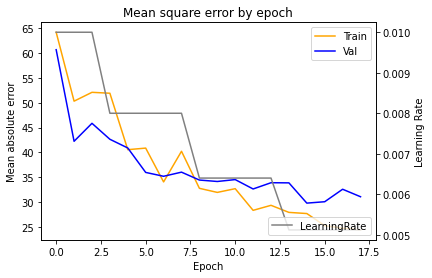

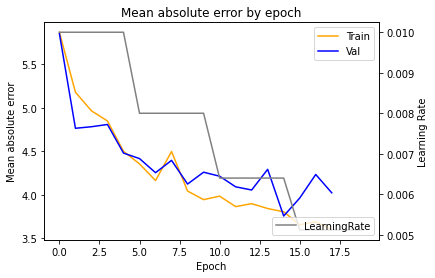

In [ ]:
h = history.history
print(h.keys())

ax1 = plt.subplot()
l1 = ax1.plot(h["loss"][2:],label="Train",color='orange')
l2 = ax1.plot(h["val_loss"][2:],label="Val",color='blue')
ax1.legend(loc=1)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Mean absolute error")

ax2 = ax1.twinx()
ax2.plot(h["lr"][2:],label="LearningRate",color='grey')
ax2.legend(loc=4)
ax2.set_ylabel("Learning Rate")

plt.title("Mean square error by epoch")
plt.savefig("/content/drive/MyDrive/IMA206/MSE_by_epoch_full_training_w_aug.png")
plt.show()

ax1 = plt.subplot()
l1 = ax1.plot(h["mean_absolute_error"][2:],label="Train",color='orange')
l2 = ax1.plot(h["val_mean_absolute_error"][2:],label="Val",color='blue')
ax1.legend(loc=1)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Mean absolute error")

ax2 = ax1.twinx()
ax2.plot(h["lr"][:],label="LearningRate",color='grey')
ax2.legend(loc=4)
ax2.set_ylabel("Learning Rate")

plt.title("Mean absolute error by epoch")
plt.savefig("/content/drive/MyDrive/IMA206/MAE_by_epoch_full_training_w_aug.png")
plt.show()


## Fine tuning

In [ ]:
vgg_transfer = tf.keras.models.load_model('/content/drive/MyDrive/IMA206/best_model_b4_fine_tune_w_aug')
vgg_transfer.get_layer('vgg16').trainable = True
vgg_transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 3)       30        
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 512)        0         
 )                                                           

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data at the end of the training the best model found")
with tf.device("/GPU:0"):
    results = vgg_transfer.evaluate(X_test, Y_test, batch_size=32)
    np.savetxt("/content/drive/MyDrive/IMA206/result before fine tuning_best model found_w_aug.txt",results)
print("test loss (MSE), test mean_absolute_error:", results)

Evaluate on test data at the end of the training the best model found
22/22 [==============================] - 5s 194ms/step - loss: 25.2988 - mean_absolute_error: 3.8182
test loss (MSE), test mean_absolute_error: [25.298805236816406, 3.8181793689727783]


In [ ]:
initial_learning_rate = 1e-5
epochs = 20
decay = initial_learning_rate / epochs

optimizer = Adam(initial_learning_rate)
vgg_transfer.compile(optimizer=optimizer,loss = "mean_squared_error", metrics = "mean_absolute_error" )

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=5,verbose=1)

checkpoint_filepath = '/content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True)
history_logger=tf.keras.callbacks.CSVLogger("/content/drive/MyDrive/IMA206/history_model_fine_tuned_w_aug.csv",append=True)


In [ ]:
with tf.device("/GPU:0"):
    history = vgg_transfer.fit(
        train_dataGen.flow(X_train, Y_train, batch_size=32,
         ),
        validation_data=train_dataGen.flow(X_val, Y_val,
         batch_size=32, 
         ),
        steps_per_epoch=len(X_train) / 32,
        epochs=epochs, 
        callbacks=[LearningRateScheduler(lr_step_decay, verbose=1),model_checkpoint_callback,tf.keras.callbacks.TerminateOnNaN(),
                    history_logger],
        verbose = 1
    )


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20
112/111 [==============================] - ETA: 0s - loss: 33.1358 - mean_absolute_error: 3.7252

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


111/111 [==============================] - 79s 677ms/step - loss: 33.1358 - mean_absolute_error: 3.7252 - val_loss: 22.7094 - val_mean_absolute_error: 3.4770 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/20
112/111 [==============================] - ETA: 0s - loss: 16.9686 - mean_absolute_error: 2.7939

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


111/111 [==============================] - 73s 656ms/step - loss: 16.9686 - mean_absolute_error: 2.7939 - val_loss: 15.7698 - val_mean_absolute_error: 2.7497 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-05.
Epoch 3/20
112/111 [==============================] - ETA: 0s - loss: 11.6951 - mean_absolute_error: 2.3507

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


111/111 [==============================] - 73s 651ms/step - loss: 11.6951 - mean_absolute_error: 2.3507 - val_loss: 9.3334 - val_mean_absolute_error: 2.1081 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1e-05.
Epoch 4/20
111/111 [==============================] - 69s 619ms/step - loss: 12.5787 - mean_absolute_error: 2.3105 - val_loss: 16.0793 - val_mean_absolute_error: 2.3874 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/20
112/111 [==============================] - ETA: 0s - loss: 13.0450 - mean_absolute_error: 2.3388

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


111/111 [==============================] - 73s 652ms/step - loss: 13.0450 - mean_absolute_error: 2.3388 - val_loss: 7.7122 - val_mean_absolute_error: 1.8948 - lr: 1.0000e-05

Epoch 6: LearningRateScheduler setting learning rate to 8.000000000000001e-06.
Epoch 6/20
112/111 [==============================] - ETA: 0s - loss: 8.9490 - mean_absolute_error: 2.0175

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


111/111 [==============================] - 73s 649ms/step - loss: 8.9490 - mean_absolute_error: 2.0175 - val_loss: 6.8185 - val_mean_absolute_error: 1.7871 - lr: 8.0000e-06

Epoch 7: LearningRateScheduler setting learning rate to 8.000000000000001e-06.
Epoch 7/20
111/111 [==============================] - 69s 620ms/step - loss: 8.6960 - mean_absolute_error: 1.9183 - val_loss: 6.8503 - val_mean_absolute_error: 1.9337 - lr: 8.0000e-06

Epoch 8: LearningRateScheduler setting learning rate to 8.000000000000001e-06.
Epoch 8/20
111/111 [==============================] - 69s 620ms/step - loss: 5.9005 - mean_absolute_error: 1.6658 - val_loss: 7.8527 - val_mean_absolute_error: 1.7670 - lr: 8.0000e-06

Epoch 9: LearningRateScheduler setting learning rate to 8.000000000000001e-06.
Epoch 9/20
112/111 [==============================] - ETA: 0s - loss: 6.0174 - mean_absolute_error: 1.6805

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


111/111 [==============================] - 73s 655ms/step - loss: 6.0174 - mean_absolute_error: 1.6805 - val_loss: 6.2658 - val_mean_absolute_error: 1.7792 - lr: 8.0000e-06

Epoch 10: LearningRateScheduler setting learning rate to 8.000000000000001e-06.
Epoch 10/20
112/111 [==============================] - ETA: 0s - loss: 6.2794 - mean_absolute_error: 1.7482

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


111/111 [==============================] - 73s 653ms/step - loss: 6.2794 - mean_absolute_error: 1.7482 - val_loss: 5.6676 - val_mean_absolute_error: 1.6233 - lr: 8.0000e-06

Epoch 11: LearningRateScheduler setting learning rate to 6.400000000000001e-06.
Epoch 11/20
112/111 [==============================] - ETA: 0s - loss: 5.0439 - mean_absolute_error: 1.5339

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


111/111 [==============================] - 73s 650ms/step - loss: 5.0439 - mean_absolute_error: 1.5339 - val_loss: 5.3134 - val_mean_absolute_error: 1.6788 - lr: 6.4000e-06

Epoch 12: LearningRateScheduler setting learning rate to 6.400000000000001e-06.
Epoch 12/20
112/111 [==============================] - ETA: 0s - loss: 4.3987 - mean_absolute_error: 1.4492

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


111/111 [==============================] - 73s 652ms/step - loss: 4.3987 - mean_absolute_error: 1.4492 - val_loss: 3.8867 - val_mean_absolute_error: 1.3781 - lr: 6.4000e-06

Epoch 13: LearningRateScheduler setting learning rate to 6.400000000000001e-06.
Epoch 13/20
111/111 [==============================] - 69s 619ms/step - loss: 4.4597 - mean_absolute_error: 1.4555 - val_loss: 4.1616 - val_mean_absolute_error: 1.4112 - lr: 6.4000e-06

Epoch 14: LearningRateScheduler setting learning rate to 6.400000000000001e-06.
Epoch 14/20
111/111 [==============================] - 69s 619ms/step - loss: 4.0638 - mean_absolute_error: 1.4090 - val_loss: 4.0467 - val_mean_absolute_error: 1.3916 - lr: 6.4000e-06

Epoch 15: LearningRateScheduler setting learning rate to 6.400000000000001e-06.
Epoch 15/20
111/111 [==============================] - 69s 619ms/step - loss: 3.7455 - mean_absolute_error: 1.3690 - val_loss: 6.1535 - val_mean_absolute_error: 1.6534 - lr: 6.4000e-06

Epoch 16: LearningRateSchedu

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug/assets


111/111 [==============================] - 72s 647ms/step - loss: 3.3264 - mean_absolute_error: 1.2529 - val_loss: 3.7181 - val_mean_absolute_error: 1.3370 - lr: 5.1200e-06

Epoch 18: LearningRateScheduler setting learning rate to 5.120000000000002e-06.
Epoch 18/20
111/111 [==============================] - 69s 619ms/step - loss: 3.1970 - mean_absolute_error: 1.2547 - val_loss: 3.8894 - val_mean_absolute_error: 1.3527 - lr: 5.1200e-06

Epoch 19: LearningRateScheduler setting learning rate to 5.120000000000002e-06.
Epoch 19/20
111/111 [==============================] - 69s 618ms/step - loss: 2.9892 - mean_absolute_error: 1.2313 - val_loss: 4.5777 - val_mean_absolute_error: 1.5920 - lr: 5.1200e-06

Epoch 20: LearningRateScheduler setting learning rate to 5.120000000000002e-06.
Epoch 20/20
111/111 [==============================] - 69s 619ms/step - loss: 3.4254 - mean_absolute_error: 1.3032 - val_loss: 3.7727 - val_mean_absolute_error: 1.3181 - lr: 5.1200e-06


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data at the end of the training")
with tf.device("/GPU:0"):
    results = vgg_transfer.evaluate(X_test, Y_test, batch_size=32)
    np.savetxt("/content/drive/MyDrive/IMA206/result after fine tuning_end of training_w_aug.txt",results)
print("test loss, test acc:", results)

Evaluate on test data at the end of the training
22/22 [==============================] - 5s 200ms/step - loss: 2.8794 - mean_absolute_error: 1.3435
test loss, test acc: [2.8794326782226562, 1.343481183052063]


dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error', 'lr'])


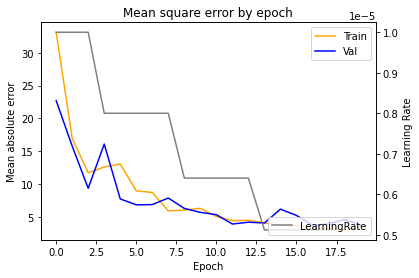

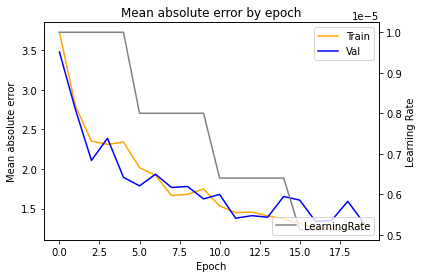

In [ ]:
h = history.history
print(h.keys())

ax1 = plt.subplot()
l1 = ax1.plot(h["loss"][:],label="Train",color='orange')
l2 = ax1.plot(h["val_loss"][:],label="Val",color='blue')
ax1.legend(loc=1)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Mean absolute error")

ax2 = ax1.twinx()
ax2.plot(h["lr"][2:],label="LearningRate",color='grey')
ax2.legend(loc=4)
ax2.set_ylabel("Learning Rate")

plt.title("Mean square error by epoch")
plt.savefig("/content/drive/MyDrive/IMA206/MSE_by_epoch_full_training_fine_tuned_w_aug.png")
plt.show()

ax1 = plt.subplot()
l1 = ax1.plot(h["mean_absolute_error"][:],label="Train",color='orange')
l2 = ax1.plot(h["val_mean_absolute_error"][:],label="Val",color='blue')
ax1.legend(loc=1)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Mean absolute error")

ax2 = ax1.twinx()
ax2.plot(h["lr"][:],label="LearningRate",color='grey')
ax2.legend(loc=4)
ax2.set_ylabel("Learning Rate")

plt.title("Mean absolute error by epoch")
plt.savefig("/content/drive/MyDrive/IMA206/MAE_by_epoch_full_training_fine_tuned_w_aug.png")
plt.show()


## Evaluate

In [ ]:
vgg_transfer = tf.keras.models.load_model('/content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug')
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data at the end of the training")
with tf.device("/GPU:0"):
    results = vgg_transfer.evaluate(X_test, Y_test, batch_size=32)
    np.savetxt("/content/drive/MyDrive/IMA206/result after fine tuning_best_model_found_w_aug.txt",results)
print("test loss, test acc:", results)

Evaluate on test data at the end of the training
22/22 [==============================] - 5s 195ms/step - loss: 4.4154 - mean_absolute_error: 1.6312
test loss, test acc: [4.415359020233154, 1.6312205791473389]


In [ ]:
X_test_rot_90 = np.rot90(X_test,k=1,axes=(1,2))
X_test_rot_180 = np.rot90(X_test,k=2,axes=(1,2))
X_test_rot_270 = np.rot90(X_test,k=3,axes=(1,2))
with tf.device("/GPU:0"):
    results_0 = vgg_transfer.predict(X_test,batch_size=32)
    results_90 = vgg_transfer.predict(X_test_rot_90, batch_size=32)
    results_180 = vgg_transfer.predict(X_test_rot_180, batch_size=32)
    results_270 = vgg_transfer.predict(X_test_rot_270, batch_size=32)
    

In [ ]:
results_0 = np.round(results_0.reshape(-1))
results_90 = np.round(results_90.reshape(-1))
results_180 = np.round(results_180.reshape(-1))
results_270 = np.round(results_270.reshape(-1))

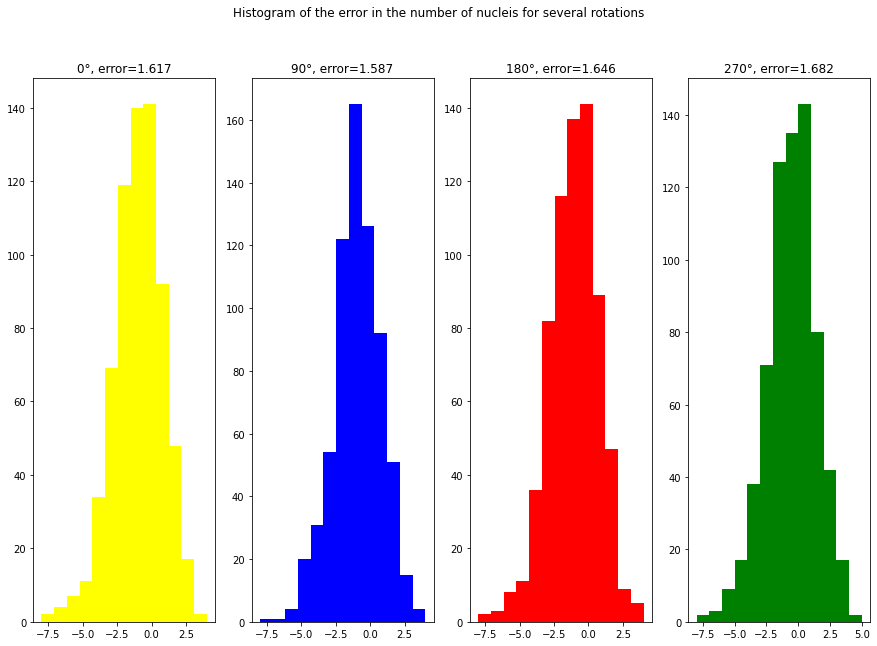

Average error 0 1.587463556851312
Average error 90 1.587463556851312
Average error 180 1.6457725947521866
Average error 270 1.6822157434402332


In [ ]:
delta_0 = Y_test - results_0
delta_90 = Y_test - results_90
delta_180 = Y_test - results_180
delta_270 = Y_test - results_270

fig, ax = plt.subplots(1,4,figsize=(15,10))
ax[0].hist(delta_0, bins=13,range=(np.min(delta_0),np.max(delta_0)), color="yellow") 
ax[0].set_title("0°, error="+ str(np.round(np.abs(delta_0).mean(),3)))
ax[1].hist(delta_90, bins=13,range=(np.min(delta_90),np.max(delta_90)), color="blue" )
ax[1].set_title("90°, error="+ str(np.round(np.abs(delta_90).mean(),3)))
ax[2].hist(delta_180, bins=13,range=(np.min(delta_180),np.max(delta_180)),color="red")
ax[2].set_title("180°, error="+ str(np.round(np.abs(delta_180).mean(),3)))
ax[3].hist(delta_270, bins=13,range=(np.min(delta_270),np.max(delta_270)),color="green" )
ax[3].set_title("270°, error="+ str(np.round(np.abs(delta_270).mean(),3)))


fig.suptitle("Histogram of the error in the number of nucleis for several rotations")
plt.savefig("/content/drive/MyDrive/IMA206/Error for each rotation with augmentation")

plt.show()
print("Average error 0",np.abs(np.abs(delta_90).mean()))
print("Average error 90",np.abs(np.abs(delta_90).mean()))
print("Average error 180",np.abs(np.abs(delta_180).mean()))
print("Average error 270",np.abs(np.abs(delta_270).mean()))


# Evaluation strategies

In [ ]:
vgg_transfer_aug = tf.keras.models.load_model('/content/drive/MyDrive/IMA206/best_model_fine_tuned_w_aug')
vgg_transfer = tf.keras.models.load_model('/content/drive/MyDrive/IMA206/best_model_fine_tuned')
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data at the end of the training with the best model found")
with tf.device("/GPU:0"):
    print("When trained on augmented data:")
    results_aug = vgg_transfer_aug.evaluate(X_test, Y_test, batch_size=32)
    print("test loss, test acc:", results_aug)
    print("Trained without augmentation")
    results = vgg_transfer.evaluate(X_test, Y_test, batch_size=32)
    print("test loss, test acc:", results)

Evaluate on test data at the end of the training with the best model found
When trained on augmented data:
22/22 [==============================] - 19s 241ms/step - loss: 4.4154 - mean_absolute_error: 1.6312
test loss, test acc: [4.415359020233154, 1.6312205791473389]
Trained without augmentation
22/22 [==============================] - 4s 176ms/step - loss: 7.8636 - mean_absolute_error: 2.2110
test loss, test acc: [7.86361026763916, 2.210982084274292]


In [ ]:
def results_rot(model,X_test):
  X_test_rot_90 = np.rot90(X_test,k=1,axes=(1,2))
  X_test_rot_180 = np.rot90(X_test,k=2,axes=(1,2))
  X_test_rot_270 = np.rot90(X_test,k=2,axes=(1,2))
  with tf.device("/GPU:0"):
    results_0 = model.predict(X_test,batch_size=32)
    results_90 = model.predict(X_test_rot_90, batch_size=32)
    results_180 = model.predict(X_test_rot_180, batch_size=32)
    results_270 = model.predict(X_test_rot_270, batch_size=32)

  return results_0, results_90, results_180, results_270

In [ ]:
def mean_voting(results_0, results_90, results_180, results_270):
  agreg_results = np.stack([results_0, results_90, results_180, results_270])
  mean_res = agreg_results.mean(axis=0).reshape(-1)
  return mean_res

def min_voting(results_0, results_90, results_180, results_270):
  agreg_results = np.stack([results_0, results_90, results_180, results_270])
  min_res = agreg_results.min(axis=0).reshape(-1)
  return min_res

def max_voting(results_0, results_90, results_180, results_270):
  agreg_results = np.stack([results_0, results_90, results_180, results_270])
  max_res = agreg_results.max(axis=0).reshape(-1)
  return max_res

def med_voting(results_0, results_90, results_180, results_270):
  agreg_results = np.stack([results_0, results_90, results_180, results_270])
  med_res = np.median(agreg_results,axis=0).reshape(-1)
  return med_res 

In [ ]:
results_0, results_90, results_180, results_270 = results_rot(vgg_transfer,X_test)

mean_res = mean_voting(results_0, results_90, results_180, results_270)
max_res = max_voting(results_0, results_90, results_180, results_270)
min_res = min_voting(results_0, results_90, results_180, results_270)
med_res = med_voting(results_0, results_90, results_180, results_270)

mae = tf.keras.losses.MeanAbsoluteError()

mean_score = mae(Y_test, mean_res).numpy()
med_score = mae(Y_test, med_res).numpy()
min_score = mae(Y_test, min_res).numpy()
max_score = mae(Y_test, max_res).numpy()

print("Result without augmentation")
print("Mean voting",mean_score)
print("Median voting",med_score)
print("Minimum voting",min_score)
print("Maximum voting",max_score)

Result without augmentation
Mean voting 1.6762279
Median voting 1.8172704
Minimum voting 2.086739
Maximum voting 2.7449956


In [ ]:
results_0_aug, results_90_aug, results_180_aug, results_270_aug = results_rot(vgg_transfer_aug,X_test)

mean_res_aug = mean_voting(results_0_aug, results_90_aug, results_180_aug, results_270_aug)
max_res_aug = max_voting(results_0_aug, results_90_aug, results_180_aug, results_270_aug)
min_res_aug = min_voting(results_0_aug, results_90_aug, results_180_aug, results_270_aug)
med_res_aug = med_voting(results_0_aug, results_90_aug, results_180_aug, results_270_aug)

mae = tf.keras.losses.MeanAbsoluteError()

mean_score_aug = mae(Y_test, mean_res_aug).numpy()
med_score_aug = mae(Y_test, med_res_aug).numpy()
min_score_aug = mae(Y_test, min_res_aug).numpy()
max_score_aug = mae(Y_test, max_res_aug).numpy()

print("Result with augmentation")
print("Mean voting",mean_score_aug)
print("Median voting",med_score_aug)
print("Minimum voting",min_score_aug)
print("Maximum voting",max_score_aug)

Result with augmentation
Mean voting 1.3960426
Median voting 1.4674456
Minimum voting 1.2822441
Maximum voting 2.177107


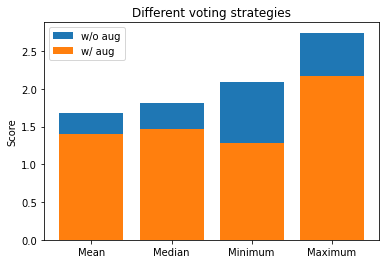

In [ ]:
names = ["Mean","Median","Minimum","Maximum"]
plt.bar(names,[mean_score,med_score,min_score,max_score],label='w/o aug')
plt.bar(names,[mean_score_aug,med_score_aug,min_score_aug,max_score_aug],label='w/ aug')
plt.ylabel("Score")
plt.title("Different voting strategies")
plt.legend()
plt.show()